In [3]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import norm

# Default plotting style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

In [4]:
def load_stock_data(name, start_date, end_date):
    return quandl.get('WIKI/' + name, start_date=start_date, end_date=end_date)['Adj. Close']

In [142]:
data = load_stock_data("AMZN", "2006-01-01", "2018-01-01")

In [143]:
df = pd.DataFrame([data]).T

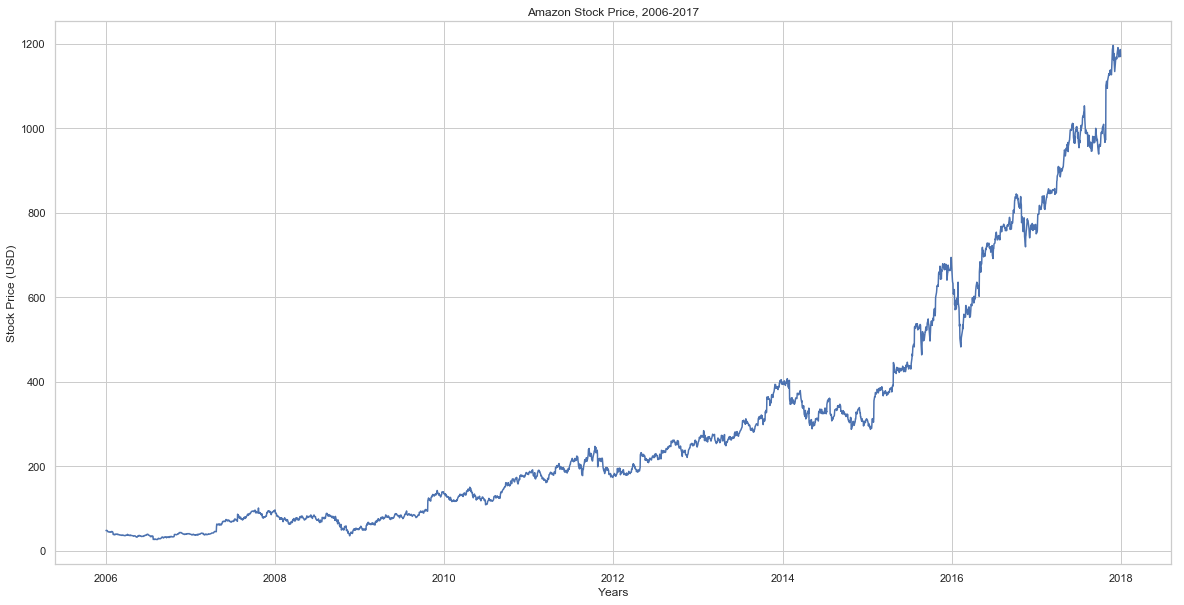

In [144]:
plt.figure(figsize=(20, 10))
plt.plot(df)
plt.ylabel("Stock Price (USD)")
plt.xlabel("Years")
plt.title("Amazon Stock Price, 2006-2017");

In [145]:
df.reset_index(level=0, inplace=True)

In [146]:
df.head()

,Date,Adj. Close
0,2006-01-03,47.58
1,2006-01-04,47.25
2,2006-01-05,47.65
3,2006-01-06,47.87
4,2006-01-09,47.08


In [147]:
df.tail()

,Date,Adj. Close
3013,2017-12-22,1168.36
3014,2017-12-26,1176.76
3015,2017-12-27,1182.26
3016,2017-12-28,1186.10
3017,2017-12-29,1169.47


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 2 columns):
Date          3018 non-null datetime64[ns]
Adj. Close    3018 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.2 KB


In [149]:
df.describe()

,Adj. Close
count,3018.000000
mean,298.814908
std,279.345424
min,26.070000
25%,81.085000
50%,204.850000
75%,375.092500
max,1195.830000


## Core variables 

In [150]:
log_returns = np.log(1 + data.pct_change())

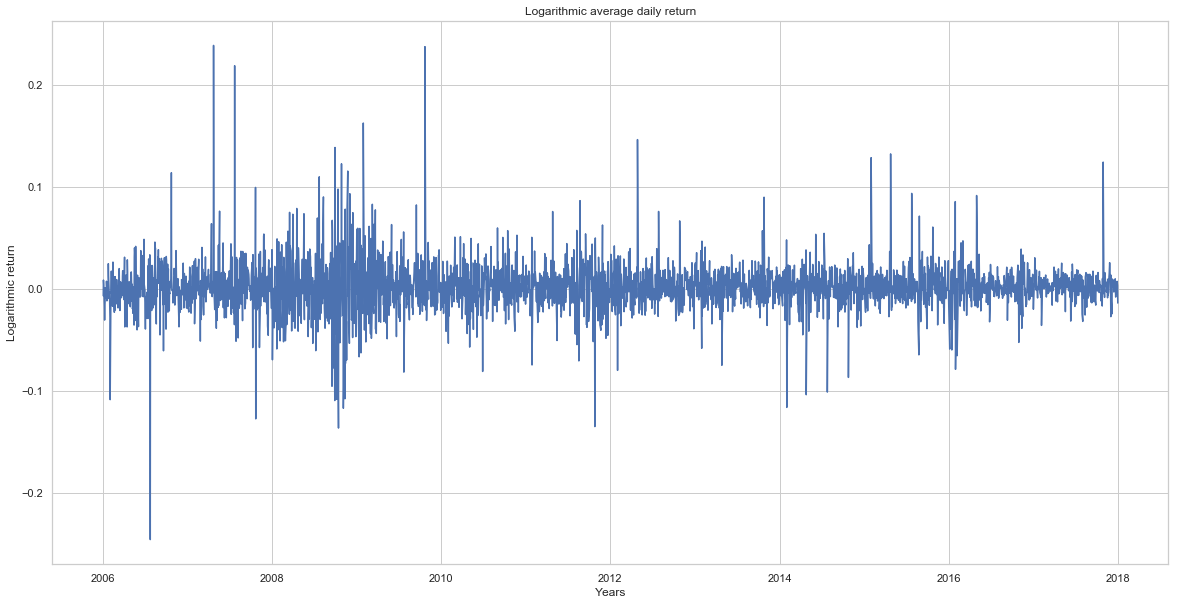

In [151]:
plt.figure(figsize=(20, 10))
plt.plot(log_returns);
plt.ylabel("Logarithmic return")
plt.xlabel("Years")
plt.title("Logarithmic average daily return");

#### Mean

In [152]:
u = log_returns.mean()

In [153]:
u

0.0010612838676938585

#### Variance

In [154]:
var = log_returns.var()

In [155]:
var

0.0006202206619998344

#### Standard deviation

In [156]:
std = log_returns.std()

In [157]:
std

0.024904229801377804

#### Drift 

In [158]:
drift = u - (0.5 * var)

In [159]:
drift

0.0007511735366939413

# Prediction

In [160]:
days = 365
itr = 10000

In [161]:
Z = norm.ppf(np.random.rand(days, itr))

In [162]:
Z

array([[ 0.69020844,  0.23334518, -0.15440131, ...,  0.53769042,
        -0.00503447,  0.12653165],
       [-0.15194933,  0.59532504,  2.09837618, ..., -1.51190918,
         0.80861553,  0.26094819],
       [-0.29603312, -2.26937043, -1.7033033 , ...,  1.08140262,
        -1.60175768, -0.04174286],
       ...,
       [-0.9348199 , -2.35777395, -0.69337115, ...,  0.41041804,
        -1.25915113,  0.52995227],
       [-0.47680948, -0.21201941,  1.70481153, ..., -0.70637196,
        -0.46026378, -0.68294626],
       [ 1.5755331 ,  0.08300751, -1.11413055, ...,  0.85072326,
        -0.92470978, -1.83217682]])

In [163]:
daily_expected_return = np.exp(drift + std * Z)

In [164]:
daily_expected_return

array([[1.01810218, 1.00658404, 0.99691071, ..., 1.01424241, 1.00062599,
        1.00390997],
       [0.99697159, 1.01569924, 1.05443978, ..., 0.96377081, 1.02110883,
        1.00727623],
       [0.99340057, 0.94576066, 0.95918791, ..., 1.0280694 , 0.96161668,
        0.99971164],
       ...,
       [0.9777221 , 0.94368074, 0.98361895, ..., 1.01103274, 0.96985664,
        1.01404697],
       [0.98893824, 0.99548123, 1.04415526, ..., 0.98330053, 0.98934582,
        0.98387436],
       [1.04079892, 1.00282239, 0.97336573, ..., 1.02218018, 0.97796831,
        0.95611433]])

In [165]:
last_closing_price = data.iloc[-1]

In [166]:
last_closing_price

1169.47

In [167]:
predicted_prices = np.zeros_like(daily_expected_return)

In [168]:
predicted_prices[0] = last_closing_price

In [169]:
for day in range(1, days):
    predicted_prices[day] = predicted_prices[day-1] * daily_expected_return[day]

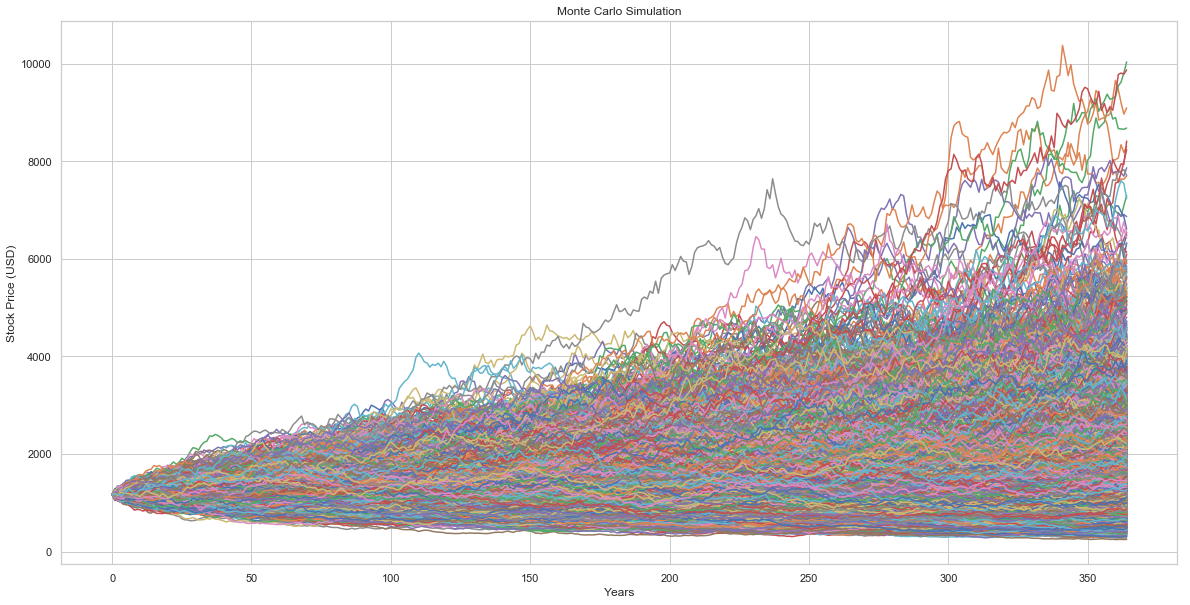

In [170]:
plt.figure(figsize=(20, 10))
plt.plot(predicted_prices)
plt.ylabel("Stock Price (USD)")
plt.xlabel("Years")
plt.title("Monte Carlo Simulation");

# Statistics

In [171]:
def run_stats(predicted_prices):
    median_expected_price = np.median(predicted_prices)
    average_expected_price = np.average(predicted_prices)
    max_expected_price = np.amax(predicted_prices)
    min_expected_price = np.amin(predicted_prices)
    
    print("Median: ", median_expected_price)
    print("Average: ",  average_expected_price)
    print("Max: ", max_expected_price)
    print("Min: ", min_expected_price)

In [172]:
run_stats(predicted_prices[364])

Median:  1525.895254545184
Average:  1719.2956192033068
Max:  10035.442332535365
Min:  250.0255142675662


### Remove Outliers

In [183]:
# How many samples to keep

# std_level: 1 = 68,2 %
# std_level: 2 = 95,4 %
# std_level: 3 = 99,6 %

def remove_outliers(predicted_prices, std_level=1):
    u = np.mean(predicted_prices)
    std = np.std(predicted_prices)
    predicted_prices_lower_bound = [x for x in predicted_prices if (x > u - std_level * std)]
    predicted_prices_no_outliers = [x for x in predicted_prices_lower_bound if (x < u + std_level * std)]
    print("Removed %d outliers" % (len(predicted_prices) - len(predicted_prices_no_outliers)))
    return predicted_prices_no_outliers

In [186]:
predicted_prices_no_outliers_std_1 = remove_outliers(predicted_prices[364], std_level=1)
predicted_prices_no_outliers_std_2 = remove_outliers(predicted_prices[364], std_level=2)
predicted_prices_no_outliers_std_3 = remove_outliers(predicted_prices[364], std_level=3)

Removed 2314 outliers
Removed 459 outliers
Removed 146 outliers


In [187]:
run_stats(predicted_prices_no_outliers_std_1)

Median:  1499.1663102658474
Average:  1559.2027729148258
Max:  2601.891496513241
Min:  836.4025284665167


In [188]:
run_stats(predicted_prices_no_outliers_std_2)

Median:  1486.28949530015
Average:  1594.5762684481165
Max:  3484.018233199427
Min:  250.0255142675662


In [189]:
run_stats(predicted_prices_no_outliers_std_3)

Median:  1513.5391024458513
Average:  1665.1143850452254
Max:  4367.425511806583
Min:  250.0255142675662


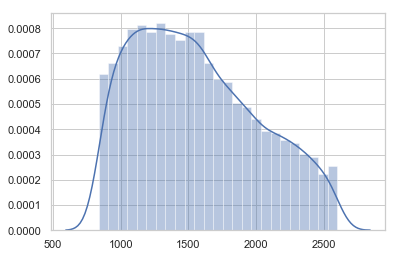

In [190]:
sbn.distplot(predicted_prices_no_outliers_std_1)

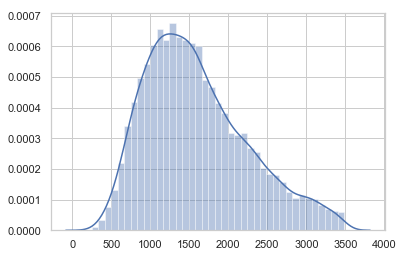

In [191]:
sbn.distplot(predicted_prices_no_outliers_std_2)

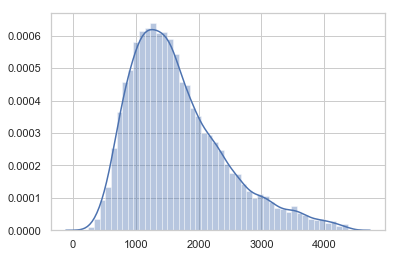

In [196]:
sbn.distplot(predicted_prices_no_outliers_std_3)